# Question 3 
### Can we accurately predict how much tips a driver will get based on distance traveled, time spent, hour of the day and day of the week?

#### Due to the limit of computation power and time, we'll be looking at it one day of the week at a time.

### Applying KNN and Regression

#### Some useful links

https://www.dataquest.io/blog/k-nearest-neighbors-in-python/ - KNN

http://www.statsoft.com/textbook/k-nearest-neighbors - Cross Validation with KNN

http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html - Selecting Classifier for Cross Validation

## Preamble

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.path as mplPath
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
%matplotlib inline

C:\Users\Victor\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Reading in the cleaned data

A. Did you check for outliers?

B. Did you check the units of all data points to make sure they are
in the right range?

C. Did you identify the missing data code?

D. Did you reformat the data properly with each instance/observation
in a row, and each variable in a column?

E. Did you keep track of all parameters and units?

F. Do you have specific code for reformating the data that does
not require information not documented (eg. magic numbers)?

G. Did you plot univariate and multivariate summaries of the data
including histograms, density plots, boxplots?

H. Did you consider correlations between variables (scatterplots)?

I. Did you consider plot the data on the right scale? For example,
on a log scale?

For the above questions, see "Cleaning the data for KNN (Q3)" notebook

In [2]:
df=pd.read_csv("datasets/clean-january-2013.csv") # tippers and non-tippers together
#df=pd.read_csv("datasets/cleaner-january-2013.csv") # only those that paid tips

In [3]:
df.head()

,Unnamed: 0,weekday,hour,pickup,trip_distance,tip_amount,total_amount,time_spent
0,0,Friday,0,"40.613763,-73.972592",0.00,7.700,38.500,0.0
1,1,Friday,0,"40.615297,-73.96423699999998",12.22,0.000,36.500,27.0
2,2,Friday,0,"40.61622,-73.97454999999998",3.70,1.625,16.375,13.0
3,3,Friday,0,"40.616755,-73.944947",1.05,0.000,6.000,3.0
4,4,Friday,0,"40.617259,-73.96366999999998",1.40,0.000,7.500,4.0


In [4]:
df.tail()

,Unnamed: 0,weekday,hour,pickup,trip_distance,tip_amount,total_amount,time_spent
14256768,14256768,Wednesday,23,"40.890857,-73.908495",0.0,4.41,7.91,1.0
14256769,14256769,Wednesday,23,"40.892463,-73.816218",13.6,0.00,3.50,0.0
14256770,14256770,Wednesday,23,"40.900912,-74.00320499999998",0.0,23.00,75.50,0.0
14256771,14256771,Wednesday,23,"40.902505,-74.00228799999998",0.0,3.00,86.00,6.0
14256772,14256772,Wednesday,23,"40.907027,-73.909115",0.0,9.50,50.50,0.0


In [5]:
df = df.loc[(df['weekday'] == 'Monday')]

### Generate the training and testing set

In [6]:
# Generate the training set.  Set random_state to be able to replicate results.
train = df.sample(frac=0.8, random_state=1)
# Select anything not in the training set and put it in the testing set.
test = df.loc[~df.index.isin(train.index)]
# Print the shapes of both sets.
print(train.shape)
print(test.shape)

(1306165, 8)
(326541, 8)


In [7]:
train.head()

,Unnamed: 0,weekday,hour,pickup,trip_distance,tip_amount,total_amount,time_spent
3396955,3396955,Monday,20,"40.776098,-73.958005",0.92,0.0,6.0,4.0
2848768,2848768,Monday,15,"40.737483,-73.99314599999998",2.10,1.0,11.5,11.0
2989905,2989905,Monday,16,"40.779788,-73.953755",1.21,0.0,8.5,7.0
2556284,2556284,Monday,11,"40.769622,-73.960004",19.70,15.5,68.0,30.0
2557787,2557787,Monday,11,"40.770664,-73.865877",13.40,7.7,46.2,23.0


In [8]:
Xtrain = train[['weekday','hour','pickup','trip_distance','total_amount','time_spent']]
ytrain = train[['tip_amount']]
Xtest = test[['weekday','hour','pickup','trip_distance','total_amount','time_spent']]
ytest = test[['tip_amount']]
Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

((1306165, 6), (1306165, 1), (326541, 6), (326541, 1))

In [9]:
Xtrain.head() # training set data we're interested in

,weekday,hour,pickup,trip_distance,total_amount,time_spent
3396955,Monday,20,"40.776098,-73.958005",0.92,6.0,4.0
2848768,Monday,15,"40.737483,-73.99314599999998",2.10,11.5,11.0
2989905,Monday,16,"40.779788,-73.953755",1.21,8.5,7.0
2556284,Monday,11,"40.769622,-73.960004",19.70,68.0,30.0
2557787,Monday,11,"40.770664,-73.865877",13.40,46.2,23.0


In [10]:
ytrain.head() # corresponding tips

,tip_amount
3396955,0.0
2848768,1.0
2989905,0.0
2556284,15.5
2557787,7.7


### Create the matrix

A. Did you transform, normalize, filter the data appropriately to solve your problem? Did you divide by max-min, or the sum, root-square-sum, or did you z-score the data? Did you justify what you did?

For this question I filtered the unnecessary data from the data in a previous notebook, generated new data from previous columns such as day of the week, hour of the day and others. I also transformed the data into a matrix into by hours, as noted below where I have 1 for the hour and 0 for the rest of the data.

B. Did you pick an appropriate set of models to solve the problem? Did you justify why these models and not others?

Using K-Nearest Neighbors Regression, we can group the factors together such that at the end of the grouping we have groups of the most similar properties, so when we predict with future data, we can fit into the best group.

C. Did you exersize the data science models/problems we described in the lectures showing what was presented?

Yes, in the powerpoint for regression we examined under and over-fitting, which our model does not show to exhibit after running it on all of the day of the weeks (see the final result notebook for Question 3). We also performed cross-validation as indicated in the powerpoint which is "Mean (over K) of Eval Error is “error” and std is “uncertainty in error estimate”", where we got "Accuracy: 0.82 (+/- 0.01)."

D. Are you using appropriate hyper-parameters? For example if you are using a KNN regression are you investigating the choice of K and whether you use uniform or distance weighting? If you are using K-means do you explain why K? If you are using PCA do you explore how many dimensions such as by looking
at the eigenvalues?

We used the default choice K of 5 from the sklearn.neighbors library as higher than 10 took too long to run, and testing 5 and 8, we found 5 to be a better match. We are using uniform distance weighting as default for KNeighborsRegressor.

In [11]:
## might be useful
pickup_train = Xtrain[['pickup']] # remember the pickup coordinates

Xtrain = Xtrain.join(pd.get_dummies(Xtrain['hour']))
Xtrain = Xtrain.drop(['hour','weekday','pickup'], axis=1)
Xtrain.head()

,trip_distance,total_amount,time_spent,0,1,2,3,4,5,6,...,14,15,16,17,18,19,20,21,22,23
3396955,0.92,6.0,4.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2848768,2.10,11.5,11.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2989905,1.21,8.5,7.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2556284,19.70,68.0,30.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2557787,13.40,46.2,23.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
## might be useful
pickup_test = Xtest[['pickup']] # remember the pickup coordinates

Xtest = Xtest.join(pd.get_dummies(Xtest['hour']))
Xtest = Xtest.drop(['hour','weekday','pickup'], axis=1)
Xtest.head()

,trip_distance,total_amount,time_spent,0,1,2,3,4,5,6,...,14,15,16,17,18,19,20,21,22,23
2002637,18.3,68.76,28.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2002645,20.1,57.30,31.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2002655,18.2,62.30,30.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2002656,11.1,42.50,22.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2002658,18.5,68.76,29.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
Xtrain.shape

(1306165, 27)

print(Xtest.shape)
Xtest.head()

### Cross Validation with KNeighborsRegressor

http://scikit-learn.org/stable/modules/cross_validation.html - 3.1.1. Computing cross-validated metrics

IV. Metrics, Validation and Evaluation 

A. Are you using appropriate choice of metrics? Are they well justified? If you are doing classification do you show an ROC curve? If you are doing regression are you justifying the metric least squares vs. mean absolute error? Do you show both?

We are doing regression for this question, and we show the root mean square error and and mean square error.

B. Do you validate your choices of hyperparamters? For example, if you use KNN or K-means do you use cross validataion to optimize your choice of parameters?

Yes, we found 5 K for KNN was optimal for our case. We used the default choice K of 5 from the sklearn.neighbors library as higher than 10 took too long to run (after running for around 2 days, no output), and testing 5 and 8, we found 5 to be a better match.

C. Do you separately evaluate testing and training error? Do you estimate the uncertainty in each? Are you also making sure that your validatation for hyperparamter optimization is kept separate from your testing? Have you avoided overfitting?

Using train-test-split to split the data, we tested on different factors and changed accordingly when an underfit/overfit was spotted. Eventually leading us to select our questions specific factors as it did not appear to underfit/overfit the data.

In [14]:
%%time
cross_validation = cross_val_score(KNeighborsRegressor(),Xtrain, ytrain,cv=5)
cross_validation

Wall time: 18min 15s


In [15]:
print("Accuracy: %0.2f (+/- %0.2f)" % (cross_validation.mean(), cross_validation.std() * 2))

Accuracy: 0.82 (+/- 0.01)


In [16]:
%%time 
clf = KNeighborsRegressor().fit(Xtrain, ytrain)
score = clf.score(Xtest, ytest)
print("Score for fold: %.3f" % (score))

Score for fold: 0.813
Wall time: 5min 27s


### Computing error


Now that we know our point predictions, we can compute the error involved with our predictions. We can compute mean squared error.

In [17]:
%%time
mse = mean_squared_error(clf.predict(Xtest),ytest)

Wall time: 3min 15s


In [18]:
print("MSE = ",mse)
print("RMSE = ",np.sqrt(mse))

MSE =  0.807310714273
RMSE =  0.898504710212


In [19]:
%%time
monday_array = clf.predict(Xtest)

Wall time: 3min 15s


Wall time: 3.05 s


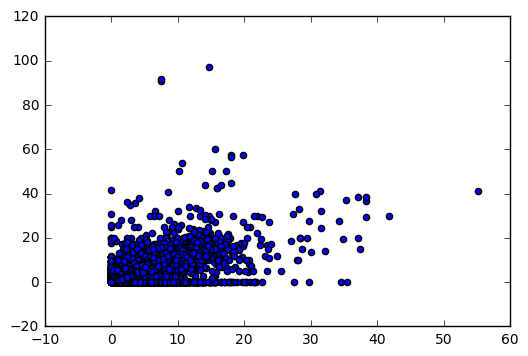

In [20]:
%%time
tip_amt = ytest.tip_amount
real_tips = []
for tips in tip_amt:
    real_tips.append(tips)
plt.scatter(monday_array,real_tips)

# Understanding the data

V. Visualization 

A. Do you provide visualization summeries for all your data and features?

Yes, below we have the visualizations and the final notebook for Q3 has for each day of the week.

B. Do you use the correct visualization type, eg. bar graphs for catigorical data, scatter plots for numerical data, etc?

Since we dealing with tips which is numerical data, yes we are using scatter plots.

C. Are your axes properly labeled?

Yes, our plots are predicted vs real and we indicate which is which on each plot.

D. Do you use color properly?

Yes, to show the difference between real vs predicted tips, using colors blue and red as they are very separate colors, easily to spot the difference

E. Do you use opacity and dot size so that scatterplots with lots of data points are not just a mass of uninterprital dots?

Rather than using opacity and dot size, since we are dealing with massive amounts of points, we chose to reduce the amount of dots to get a clearer visual plot.

F. Do you write captions explaining what a reader should conclude from each figure (not just saying what it is but what it tells you)?

Yes, see below; this translates into the final notebook as each graph is visually similar to one another


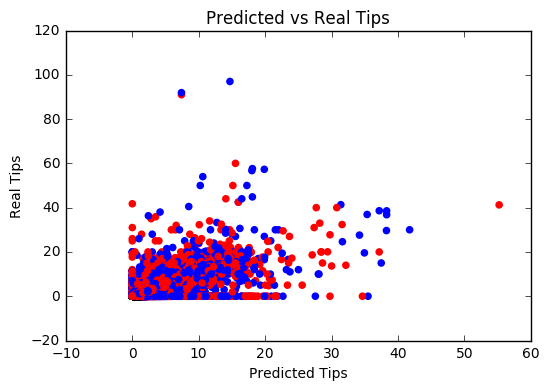

Wall time: 22.7 s


In [21]:
%%time
plt.scatter(monday_array,real_tips,color=['red','blue'])
plt.title('Predicted vs Real Tips')
plt.xlabel('Predicted Tips')
plt.ylabel('Real Tips')
plt.show()

Caption: From this graph, we can get an understanding that our predicted vs real is close together, but we will need to get a clearer picture with reduces x-lim and y-lim along with less points

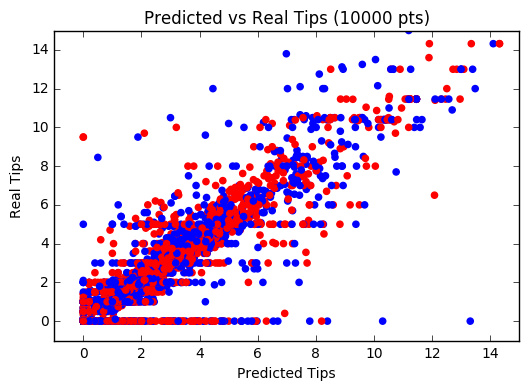

Wall time: 998 ms


In [22]:
%%time
plt.scatter(monday_array[:10000],real_tips[:10000],color=['red','blue'])
plt.xlim(-1,15)
plt.ylim(-1, 15)
plt.title('Predicted vs Real Tips (10000 pts)')
plt.xlabel('Predicted Tips')
plt.ylabel('Real Tips')
plt.show()

Caption: From this graph, Reducing the plot by half the amount of points, we also reduce the limit, we can see we have a great correlation between the predicted vs real.

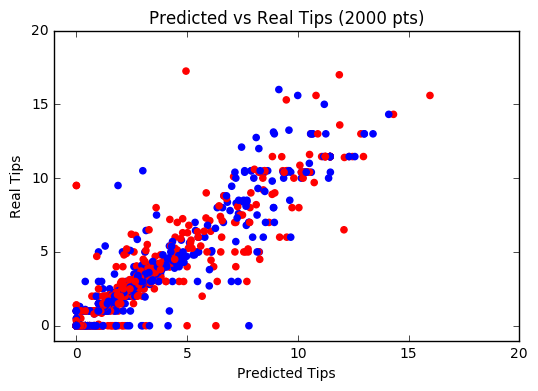

Wall time: 365 ms


In [23]:
%%time
plt.scatter(monday_array[:2000],real_tips[:2000],color=['red','blue'])
plt.xlim(-1,20)
plt.ylim(-1, 20)
plt.title('Predicted vs Real Tips (2000 pts)')
plt.xlabel('Predicted Tips')
plt.ylabel('Real Tips')
plt.show()

Caption: From this graph,  Reducing the plot to 2000 points, we also increase the limit slightly, we can see we have a great correlation between the predicted vs real, supporting our 80% prediction rate.

In [24]:
k = np.column_stack((monday_array,real_tips))

In [25]:
print("Predicted vs Real")
print("Show the data")
k[:50]

Predicted vs Real
Show the data


array([[ 11.076,  11.46 ],
       [  1.   ,   0.   ],
       [  7.56 ,   5.   ],
       [  7.702,   8.5  ],
       [ 12.318,  11.46 ],
       [  9.47 ,  10.4  ],
       [  2.19 ,   0.   ],
       [  0.   ,   0.   ],
       [ 11.246,  11.46 ],
       [  0.2  ,   0.   ],
       [ 12.964,  11.46 ],
       [  5.36 ,   7.   ],
       [ 11.458,  11.46 ],
       [  8.9  ,   8.   ],
       [  8.852,  11.46 ],
       [  0.4  ,   1.   ],
       [  3.1  ,   5.   ],
       [ 11.458,  11.45 ],
       [  8.12 ,   8.2  ],
       [  7.89 ,  10.5  ],
       [  7.88 ,   9.   ],
       [  0.4  ,   0.   ],
       [  7.1  ,  10.1  ],
       [  7.216,   8.3  ],
       [  6.064,   6.4  ],
       [ 11.39 ,  10.   ],
       [  0.   ,   9.5  ],
       [  8.844,   9.8  ],
       [ 11.46 ,  11.46 ],
       [  0.   ,   0.   ],
       [  0.   ,   0.   ],
       [  5.8  ,   6.   ],
       [  9.5  ,   6.   ],
       [  0.   ,   0.   ],
       [  1.   ,   0.   ],
       [ 11.46 ,  11.45 ],
       [  0.8  ,   0.   ],
 